In [3]:
# Imports
import tensorflow as tf
from tensorflow import keras 
from keras.models import Model
from keras.layers import Conv2D, Dense, Dropout, Input, Flatten, Conv1D, MaxPool1D

from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os

# For audio analysis
import librosa 
import librosa.display

# Progress bar
from tqdm import tqdm 

# For Audio and Spectrogram Augmentation

# !pip install audiomentations 
from audiomentations import Compose, AddGaussianNoise, TimeStretch, \
                            PitchShift, Shift, AddShortNoises, TimeMask, AddGaussianSNR, TanhDistortion
import soundfile as sf

import random

import json

plt.style.use('seaborn')
print(tf.__version__)
print("Done")

2.9.2
Done


In [5]:
# Load the folder with the audio
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/Shareddrives/Megathon/WAV/new_converted/'
labels = os.listdir(PATH)

print("Done")

Mounted at /content/drive
Done


In [ ]:
# We first converted all mp3 audio files to .wav format (faster processing and efficient use of libraries)

# Script made to convert mp3 -> wav

'''
filenames = []
outputnames = []

for label in tqdm(labels[1:]):
    i = 0
    for audio_file in os.listdir(PATH + label):

        filename = PATH + label + "/" + audio_file
        name = audio_file.split(".")
        outputname = "/content/drive/Shareddrives/Megathon/WAV/new_converted/" + label + "/" + name[0] + ".wav"
        sound = AudioSegment.from_mp3(filename)
        sound.export(outputname, format="wav")
        print(outputname)
        i = i + 1
'''

In [6]:
# Extract top k frequent audio classes (because rest have number of datapoints < 10)
# Note that we can extend our approach to other labels as well, given more time and resources

filenames = []
outcome = []

for label in labels:
    for audio_file in os.listdir(PATH + label):
        filenames.append(PATH + label + "/" + audio_file)
        outcome.append(label)

df = pd.DataFrame({
    'filename' : filenames,
    'outcome' : outcome
})

df_vc = df['outcome'].value_counts().reset_index()[:30]
df_vc.columns = ['name', 'count']
df_vc[:5]

,name,count
0,english,492
1,spanish,129
2,arabic,81
3,mandarin,52
4,french,50


In [7]:
# Oversampling
# Increasing the sample space by splitting the audio files into frames
# Each Audio sample's time series data is stored as each element in frames

frames = []
new_labels = []

for label in tqdm(df_vc['name']):
    df_temp = df[df['outcome'] == label]
    count = df_vc[df_vc['name'] == label]['count'].values[0]

    if 50 >= count >= 10:
        df1, df2 = train_test_split(df_temp, train_size = 10)
        for name in df1['filename']:
            sig, sr = librosa.load(name, res_type = 'kaiser_fast')
            frame = librosa.util.frame(sig, frame_length = 10 * sr, hop_length = 5 * sr, axis = 0)
            frames.extend(frame)
            new_labels.extend([label] * len(frame))

        for name in df2['filename']:
            sig, sr = librosa.load(name, res_type = 'kaiser_fast', duration = 10)
            frames.extend([sig])
            new_labels.append(label)
        
        # print(len(frames), len(new_labels))

    elif count < 10:
        for name in df_temp['filename']:
            sig, sr = librosa.load(name, res_type = 'kaiser_fast')
            frame = librosa.util.frame(sig, frame_length = 10 * sr, hop_length = 5 * sr, axis = 0)
            frames.extend(frame)
            new_labels.extend([label] * len(frame))
    else:
        for name in df_temp.sample(n = min(count, 100))['filename']:
            sig, sr = librosa.load(name, res_type = 'kaiser_fast', duration = 10)
            frames.extend([sig])
            new_labels.append(label)

len(frames), len(new_labels)

100%|██████████| 30/30 [17:36<00:00, 35.22s/it]


(1932, 1932)

In [8]:
# Storing the audio files grouped by their label

# key = label, value = frames_of_label
frame_dict = {}

for i in range(len(frames)):
    if new_labels[i] not in frame_dict:
        frame_dict[new_labels[i]] = [frames[i]]
    else:
        frame_dict[new_labels[i]].append(frames[i])

print("Done")

Done


In [9]:
# Audio File Augmentation
# To make sure that all labels have 100 datapoints, we're synthesizing data
# using Audio Augmentation (by adding noise, time shifting and more)

def synthesize_data_audio(frames_of_label, label):
    """
    Synthesizes audio files with respect to one label (one language)
    """
    # df2 = df[df['outcome'] == label]

    if len(frames_of_label) > 100:
        synth_frames = frames_of_label[:100]
        synth_labels = [label] * len(frames_of_label)
        return synth_frames, synth_labels

    augment = Compose([
        AddGaussianNoise(min_amplitude=0.000001, max_amplitude=0.00005, p=0.5),
        TimeStretch(min_rate=0.97, max_rate=1.05, p=0.5),
        Shift(min_fraction=-0.1, max_fraction=0.1, p=0.3),
        TimeMask(min_band_part=0.0005, max_band_part=0.001, fade=True, p=0.3),
    ])

    synth_frames = list(frames_of_label)
    synth_labels = [label] * len(frames_of_label)

    # number of frames to synthesize
    num_synth = 100

    # sampling rate (at what rate is it sampling)
    sr = 22050

    for i in range(num_synth - len(frames_of_label)):
        # randomly choose an audio sample
        frame = random.choice(frames_of_label)
        augmented_signal = augment(frame, sr)
        synth_frames.append(augmented_signal)
        synth_labels.append(label)

    return synth_frames, synth_labels

# synthesize_data_audio(df2, 'hindi')

augmented_frames = []
augmented_labels = []

top30 = df['outcome'].value_counts()[:30].index.tolist()

for label in tqdm(top30):
    
    synth_frames, synth_labels = synthesize_data_audio(frame_dict[label], label)
    augmented_frames.extend(synth_frames)
    augmented_labels.extend(synth_labels)

print("aug frames -")
print(augmented_frames[:5])
print("aug labels - ")
print(augmented_labels[:5])
print("\n--- Done ---")


100%|██████████| 30/30 [01:11<00:00,  2.40s/it]

aug frames -
[array([-0.00050128,  0.00120264,  0.00398494, ...,  0.06498273,
        0.07311676,  0.085912  ], dtype=float32), array([-2.5907140e-05, -2.5474981e-05,  1.1168807e-05, ...,
        1.1118318e-02,  3.7805722e-03,  6.4079682e-03], dtype=float32), array([-0.00014149, -0.00020588, -0.00012798, ...,  0.0003859 ,
        0.00038687,  0.00027097], dtype=float32), array([-0.00129746, -0.00168986, -0.00206407, ..., -0.01713795,
       -0.01651185, -0.05745077], dtype=float32), array([-0.00032306, -0.00046929,  0.00068082, ..., -0.01146227,
        0.01050493,  0.01390033], dtype=float32)]
aug labels - 
['english', 'english', 'english', 'english', 'english']

--- Done ---


In [10]:
# Feature Extraction and Model Compilation
# Feature Extraction - Each audio file's time series data is converted to 
# Model Compilation  - CNN's layers are defined

def extract_feature(data):
    mfccs_features = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=50)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

def cnn_model():
    inp = keras.layers.Input(shape = (50, 1))
    x = Conv1D(128, 2, activation = 'relu', kernel_regularizer = keras.regularizers.L2(1e-4))(inp)
    x = MaxPool1D(2)(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(256, 2, activation = 'relu', kernel_regularizer = keras.regularizers.L2(1e-4))(x)
    x = MaxPool1D(2)(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(128, 2, activation = 'relu', kernel_regularizer = keras.regularizers.L2(1e-4))(x)
    x = MaxPool1D(2)(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)

    x = Dense(256, activation = 'relu', kernel_regularizer = keras.regularizers.L2(1e-4))(x)
    x = Dropout(0.2)(x)
    out = Dense(30, activation = 'softmax')(x)

    model = keras.models.Model(inputs = inp, outputs = out)
    return model

augmented_frames = np.array(augmented_frames)
augmented_labels = np.array(augmented_labels)

features = []
for filename in tqdm(augmented_frames):
    features.append(extract_feature(filename))
print("Feature Extraction Complete")

features = np.array(features)
features = np.reshape(features, (-1, 50, 1))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(augmented_labels)
y = keras.utils.to_categorical(y)
print("Label Extraction Complete")

model = cnn_model()

model.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = ['accuracy']
)

print("Model Compliled")

print(model.summary())

train_x, test_x, train_y, test_y = train_test_split(features, y, train_size = 0.9)
print("Shapes: ", train_x.shape, train_y.shape, test_x.shape, test_y.shape)

print("Model Fit -")
model.fit(train_x, train_y, epochs = 100, batch_size = 128, validation_data = [test_x, test_y])


100%|██████████| 3000/3000 [01:46<00:00, 28.29it/s]


Feature Extraction Complete
Label Extraction Complete
Model Compliled
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 49, 128)           384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 256)           65792     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 256)          0 

In [11]:
!mkdir -p saved_model
model.save('/content/drive/Shareddrives/Megathon/saved_model/my_model.h5')

print("saved!")

saved!


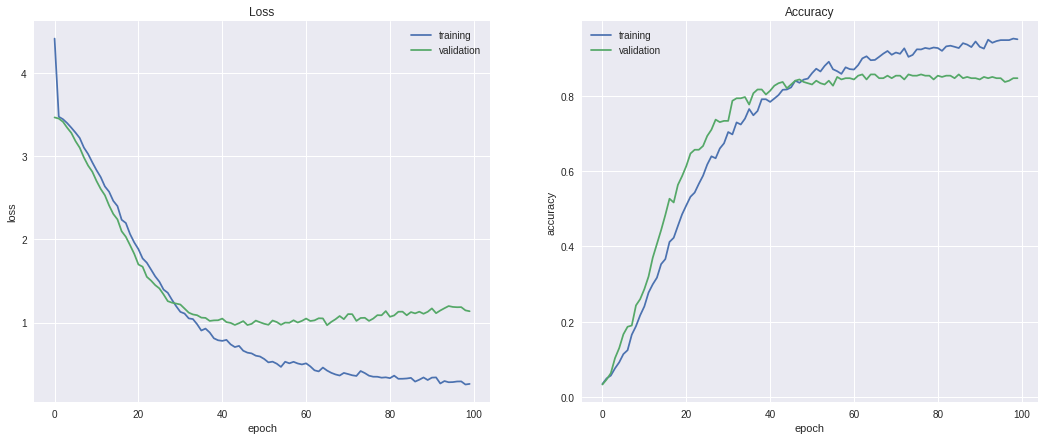

In [12]:
plt.figure(figsize = (18, 7))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(model.history.history['loss'], label='training')
plt.plot(model.history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(model.history.history['accuracy'], label='training')
plt.plot(model.history.history['val_accuracy'], label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()


In [13]:
y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis = 1)
test_y_mod = np.argmax(test_y, axis = 1)

f1_score(test_y_mod, y_pred, average='weighted')

10/10 [==============================] - 0s 9ms/step


0.8331698454849302

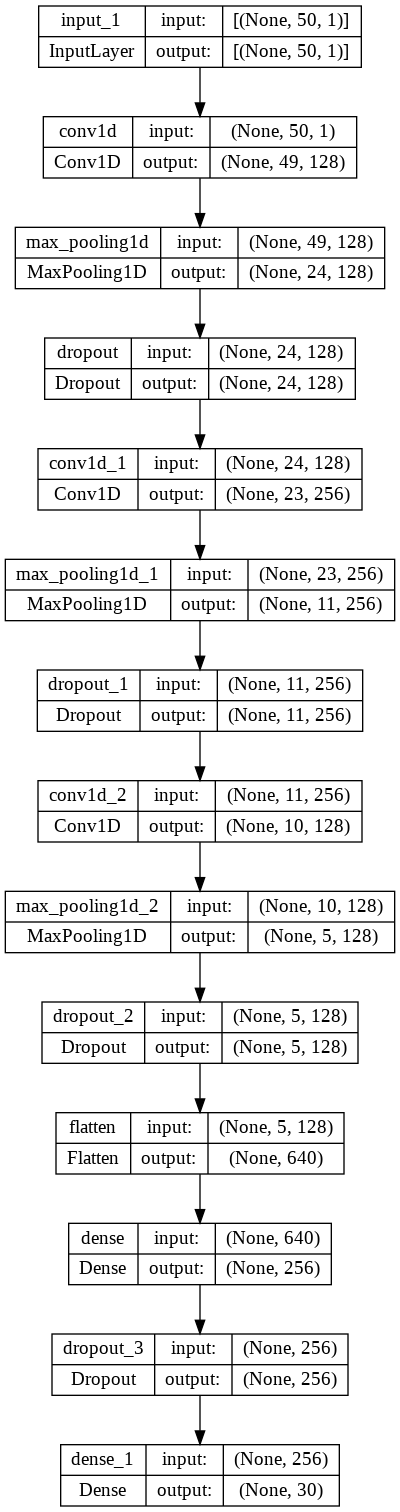

In [14]:
keras.utils.plot_model(model, 'model.png', show_shapes = True)

'hindi'

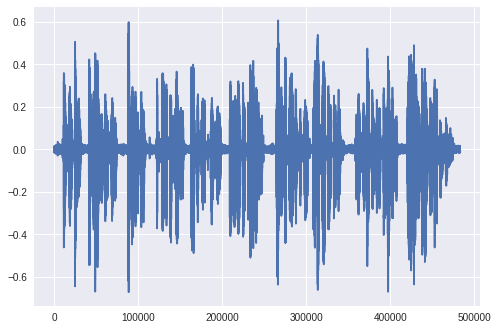

In [15]:
def predict(path):
    sig, sr = librosa.load(path, res_type = 'kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=50)
    mfcc = np.array(np.mean(mfccs_features.T,axis=0))
    mfcc = np.reshape(mfcc, (1, -1, 1))

    plt.plot(sig)
    # print(mfcc.shape)
    pred = np.argmax(model.predict(mfcc, verbose = 0))
    pred = le.inverse_transform([pred])
    return pred[0]

datapoint_path = df[df['outcome'] == 'hindi'].iloc[0, 0]
predict(datapoint_path)

# Our model predicted Hindi correctly!